## Test a Gyro GP relation in PyStan

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pystan

npts = 25
mass = np.sort(np.random.randn(npts) * 0.2 + 1.2)
period_true = 2.0 * 10**1.0 * mass**-0.5
period_spread = period_true + .2 * np.random.randn(len(mass))

obs_noise = mass * 0.4 * np.random.randn(npts)
sigma = mass * 0.4

obs_period = obs_noise + period_spread
fig, ax = plt.subplots()
ax.plot(mass, period_true)
ax.scatter(mass, obs_period,zorder=1)
ax.errorbar(mass, obs_period, yerr=sigma, fmt='|',zorder=0)
ax.set_xlabel('mass')
ax.set_ylabel('period')
plt.show()

<Figure size 1200x900 with 1 Axes>

In [3]:
from scipy import stats
slope, intercept, _, _, _ = stats.linregress(mass, obs_period)
slope, intercept


(-7.924260174824115, 27.979366283539406)

In [4]:
gpfit = '''
data {
    int<lower=1> N;
    real M[N];
    vector[N] P;
    real sigma[N];
}
transformed data{
    real delta = 1e-9;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> rho;
    real m0;
    real c0;
    vector[N] eta;
}
transformed parameters{
    vector[N] f;
    {
        vector[N] mu;
        matrix[N, N] L_K;
        matrix[N, N] K = cov_exp_quad(M, alpha, rho);
        
        // diagonal elements
        for (n in 1:N){
            K[n, n] = K[n, n] + delta;
            mu[n] = m0 * M[n] + c0;
        }
        
        L_K = cholesky_decompose(K);
        f = mu + L_K * eta;
    }
}
model {
    rho ~ inv_gamma(5, 5);
    alpha ~ std_normal();
    eta ~ std_normal();
    
    m0 ~ normal(-10, 3);
    c0 ~ normal(25, 10);
    
    P ~ normal(f, sigma);
}
'''
sm = pystan.StanModel(model_code = gpfit, model_name='gpfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL gpfit_3c120451f132e54078c9add38f313c59 NOW.


In [5]:
data = {'N' : len(mass),
       'P' : obs_period,
       'sigma' : sigma,
       'M' : mass}
init = {'alpha' : 0.4,
        'rho' : 1.,
         'm0' : slope,
         'c0' : intercept}

In [6]:
fit = sm.sampling(data=data, iter=10000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [7]:
print(fit)

Inference for Stan model: gpfit_3c120451f132e54078c9add38f313c59.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha     0.87    0.03   0.63   0.04   0.37   0.75   1.27   2.26    371   1.01
rho       1.21  7.2e-3   0.71   0.48   0.76   1.03   1.47    3.0   9741    1.0
m0       -8.46    0.01    1.0 -10.71  -8.99  -8.42  -7.89  -6.46   5112    1.0
c0       28.73    0.13   1.66  24.49  27.94  28.69  29.52   32.4    174   1.02
eta[1]   -0.16    0.06   1.02  -2.08  -0.86  -0.19    0.5   1.96    313   1.01
eta[2]   -0.21  9.1e-3   0.95  -2.06  -0.84  -0.26   0.41    1.7  10970    1.0
eta[3]    0.34    0.04   1.02  -1.66  -0.35   0.33   1.03   2.24    748   1.01
eta[4]    0.06  8.5e-3   0.99   -1.9  -0.59   0.05   0.71   2.04  13362    1.0
eta[5]    0.18    0.05   1.03  -1.82  -0.54   0.16   0.87   2.21    353   1.01
eta[6]    0.15    0.01  

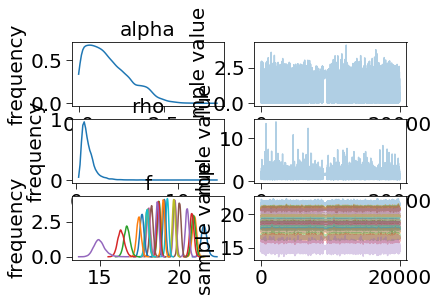

In [8]:
fit.plot(pars=['alpha','rho','f'])
plt.show()

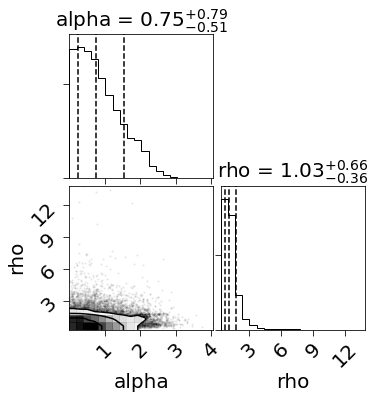

In [9]:
import corner
labels=['alpha','rho']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels,
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

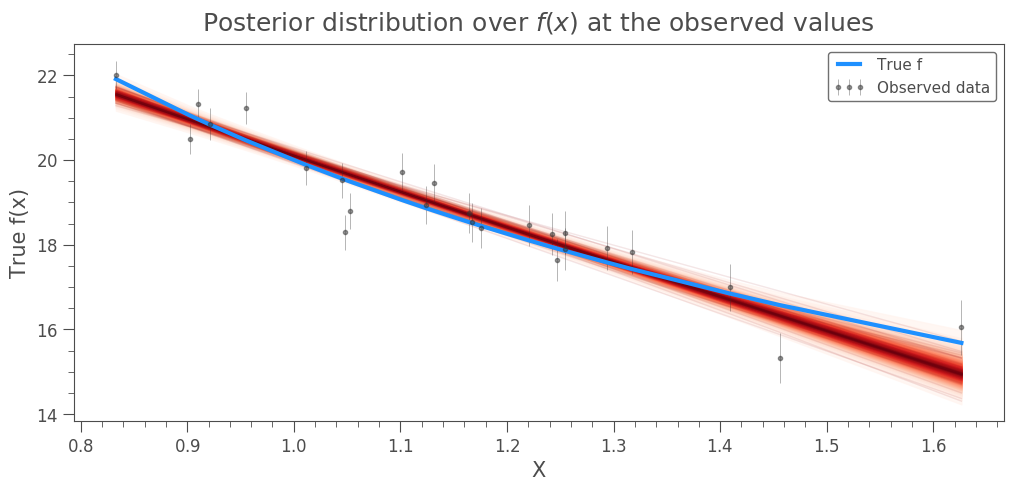

In [15]:
import mystyle
with plt.style.context(mystyle.ms):
    fig = plt.figure(figsize=(12,5)); ax = fig.gca()

    from pymc3.gp.util import plot_gp_dist
    plot_gp_dist(ax, fit["f"], mass);

    # plot the data and the true latent function
    plt.plot(mass, period_true, "dodgerblue", lw=3, label="True f");
    plt.errorbar(mass, obs_period, yerr=sigma, fmt='o', ms=3, alpha=0.5, label="Observed data");

    # axis labels and title
    plt.xlabel("X"); plt.ylabel("True f(x)");
    plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();